# SpiNNaker Synfire Example
This is an example of a Synfire Chain build on SpiNNaker, using the PyNN Neural Network language.

First we import sPyNNaker through pyNN.  We have specified that the name that the simulator will use in the rest of the script is ```p``` but this can be anything desired.

In [1]:
import pyNN.spiNNaker as p

Here we set up some constants that will be useful in our script

In [2]:
n_neurons = 100
n_populations = 10
weights = 0.5
delays = 17.0
simtime = 1000

Next we must call setup to initialize SpiNNaker.  The ```timestep``` argument indicates the time step of the simulation in milliseconds.

In [3]:
p.setup(timestep=1.0)

2019-05-14 11:11:10 INFO: Read config files: /home/jovyan/sPyNNaker/local/lib/python2.7/site-packages/spinn_front_end_common/interface/spinnaker.cfg, /home/jovyan/sPyNNaker/local/lib/python2.7/site-packages/spynnaker/pyNN/spynnaker.cfg, /home/jovyan/.spynnaker.cfg
2019-05-14 11:11:10 INFO: Will search these locations for binaries: /home/jovyan/sPyNNaker/local/lib/python2.7/site-packages/spinn_front_end_common/common_model_binaries : /home/jovyan/sPyNNaker/local/lib/python2.7/site-packages/spynnaker/pyNN/model_binaries
2019-05-14 11:11:10 INFO: Setting time scale factor to 1.
2019-05-14 11:11:10 INFO: Setting machine time step to 1000.0 micro-seconds.


['/home/jovyan/sPyNNaker/local/lib/python2.7/site-packages/spinn_front_end_common/interface/spinnaker.cfg', '/home/jovyan/sPyNNaker/local/lib/python2.7/site-packages/spynnaker/pyNN/spynnaker.cfg', '/home/jovyan/.spynnaker.cfg']


0

PyNN calls each groups of neurons a Population.  Each Population has a number of neurons, and a cell type indicating the model of the neurons being simulation.  The cell type can be given parameters to control its behaviour; most neuron models accept an ```i_offset``` parameter, which defines a constant input current to the neuron, in nano-Amps.

PyNN supports several models, e.g. ```IF_curr_exp```, ```IF_cond_exp```, ```Izhikavich```, as well as some 'input' models, which provide stimulation, e.g. ```SpikeSourceArray``` and ```SpikeSourcePoisson```.

Here we create a stimulation Population from a ```SpikeSourceArray``` model with a single neuron.  This will send a spike at time 0, i.e. the start of the simulation.

In [4]:
stimulus = p.Population(1, p.SpikeSourceArray(spike_times=[0]), label='stimulus')

We next create a list of Population objects, which will become the synfire chain.  Each of these is of type ```IF_curr_exp```, which means a Leaky-Integrate-and-Fire neuron model, with one excitatory and one inhibitory exponentially-decaying, current-based synaptic input per neuron.  This is set up to use the default parameters, since no parameters are specified.

In [5]:
chain_pops = [
    p.Population(n_neurons, p.IF_curr_exp(), label='chain_{}'.format(i))
    for i in range(n_populations)
]

As we would like to see the output spikes from each population, we can ask for them to be recorded.  It is also possible to record the membrane voltage using the parameter ```"v"```.

In [6]:
for pop in chain_pops:
    pop.record("spikes")

We now need to connect our Population objects together so that the spikes from one Population cause the next to spike and so on, in a loop.  Additionally, the last Population is connected to cause the first to spike again.

Populations are connected together in PyNN using a Projection object.  This takes the source and target Population objects as arguments; note that the Projections are uni-directional, though a Projection can be created for each direction if a bi-directional relationship is required.

The Projection additionally requires a connector, which describes the connections between the individual neurons in the source Population to those in the target Population.  For example, a OneToOneConnector connects each source neuron to its corresponding target neuron, whereas a FixedProbabilityConnector makes connections at random with a defined probability.

Finally, the type of the synapses must be specified.  This determines the weights (i.e. strengths, in nano-Amps for current-based projections, or micro-Siemens for conductance based ones).  Synaptic plasticity can also be described here.

In the example here, we are using a FixedNumberPreConnector, which means 10 pre-synaptic neurons chosen at random are connected to all the post-synaptic neurons.  The Projection is created with static (i.e. non-plastic) synapses all with the same weight and delay value.

In [7]:
connector = p.FixedNumberPreConnector(10)
for i in range(n_populations):
    p.Projection(
        chain_pops[i], chain_pops[(i + 1) % n_populations], 
        connector, synapse_type=p.StaticSynapse(weight=weights, delay=delays))

2019-05-14 11:11:10 WARNING: The end user entered a max delay for which the projection breaks
2019-05-14 11:11:10 WARNING: The end user entered a max delay for which the projection breaks
2019-05-14 11:11:10 WARNING: The end user entered a max delay for which the projection breaks
2019-05-14 11:11:10 WARNING: The end user entered a max delay for which the projection breaks
2019-05-14 11:11:10 WARNING: The end user entered a max delay for which the projection breaks
2019-05-14 11:11:10 WARNING: The end user entered a max delay for which the projection breaks
2019-05-14 11:11:10 WARNING: The end user entered a max delay for which the projection breaks
2019-05-14 11:11:10 WARNING: The end user entered a max delay for which the projection breaks
2019-05-14 11:11:10 WARNING: The end user entered a max delay for which the projection breaks
2019-05-14 11:11:10 WARNING: The end user entered a max delay for which the projection breaks


We additionally create a Projection from the stimulus Population to the first of the chain Populations.  Without this, there is no other source of spikes in the network, so nothing would happen.

In [8]:
p.Projection(stimulus, chain_pops[0], p.AllToAllConnector(), synapse_type=p.StaticSynapse(weight=5.0))

projection projection edge 10

The neural network has now been defined.  Up to this point, no code has been run on SpiNNaker.  The next step is to run the network, which will perform all the steps needed to convert the PyNN network into a running SpiNNaker network.

The run call takes a single parameter, which is the duration of the simulation in milliseconds.  This can be called multiple times, and the results can be read in between calls to run, and parameter values can be set to new values for the next run.  This can be particularly useful for providing a varying background current through modification of the ```i_offset``` of the neurons, or to vary the ```rate``` of a ```SpikeSourcePoisson```, or provide additional spike times for a ```SpikeSourceArray``` (though note that new times should be relative to the current simulation time).

In [9]:
p.run(simtime)

2019-05-14 11:11:10 INFO: Simulating for 1 1000.000000ms timesteps using a hardware timestep of 1000000us
2019-05-14 11:11:10 INFO: Starting execution process
2019-05-14 11:11:10 INFO: Time 0:00:00.003072 taken by SpallocMaxMachineGenerator
2019-05-14 11:11:10 INFO: Time 0:00:00.434646 taken by VirtualMachineGenerator
Allocating virtual identifiers
|0%                          50%                         100%|
2019-05-14 11:11:58 INFO: Time 0:00:47.715055 taken by MallocBasedChipIDAllocator
Partitioning graph vertices
|0%                          50%                         100%|
Partitioning graph edges
|0%                          50%                         100%|
2019-05-14 11:11:58 INFO: Time 0:00:00.240041 taken by PartitionAndPlacePartitioner
Created spalloc job 4608532
2019-05-14 11:11:58 INFO: Created spalloc job 4608532
Waiting for board power commands to complete.
2019-05-14 11:11:58 INFO: Waiting for board power commands to complete.
2019-05-14 11:12:19 INFO: Time 0:00:20.58

2019-05-14 11:12:41 INFO: *** Awaiting for a response from an external source to state its ready for the simulation to start ***
2019-05-14 11:12:41 INFO: *** Sending start / resume message to external sources to state the simulation has started or resumed. ***
2019-05-14 11:12:41 INFO: *** Awaiting for a response from an external source to state its ready for the simulation to start ***
2019-05-14 11:12:41 INFO: Application started - waiting 1.1 seconds for it to stop
2019-05-14 11:12:42 INFO: *** Sending pause / stop message to external sources to state the simulation has been paused or stopped. ***
2019-05-14 11:12:42 INFO: Time 0:00:01.265424 taken by ApplicationRunner
Getting provenance data
|0%                          50%                         100%|
2019-05-14 11:12:42 INFO: Time 0:00:00.054881 taken by PlacementsProvenanceGatherer
Getting Router Provenance
|0%                          50%                         100%|
2019-05-14 11:12:42 INFO: Time 0:00:00.148043 taken by Rou

1000.0

Once the simulation has run, the recorded data can be retrieved and processed.  Reading back the data is simply done by calling ```get_data``` on the Population object.  Recorded data is returned using ```neo```, which contains a ```segment``` for every call to ```run``` following a call to ```reset``` (which resets the simulation back to time = 0); so if ```reset``` has never been called, there will be exactly one segment with index 0.  The spike data is stored in a ```spiketrains``` object, with one spike train per neuron, consisting of an array of times at which that neuron spiked.  The data also contains other annotations, such as the ```source_index``` of the data which indicates the id of the first neuron in the Population.

In the example below, the spikes from all the Population objects are processed into a list of spike trains, and an increasing offset is added to the ```source_index``` of each spike train to make them unique across all populations.

In [10]:
neo_data = [pop.get_data("spikes") for pop in chain_pops]

spike_trains = [neo.segments[0].spiketrains for neo in neo_data]
offset = 0
for spike_train_list in spike_trains:
    for spike_train in spike_train_list:
        spike_train.annotations["source_index"] += offset
    offset += n_neurons

Getting spikes for chain_0
|0%                          50%                         100%|
Getting spikes for chain_1
|0%                          50%                         100%|
Getting spikes for chain_2
|0%                          50%                         100%|
Getting spikes for chain_3
|0%                          50%                         100%|
Getting spikes for chain_4
|0%                          50%                         100%|
Getting spikes for chain_5
|0%                          50%                         100%|
Getting spikes for chain_6
|0%                          50%                         100%|
Getting spikes for chain_7
|0%                          50%                         100%|
Getting spikes for chain_8
|0%                          50%                         100%|
Getting spikes for chain_9
|0%                          50%                         100%|


Once you have run the simulation and extracted all the data you want, you should end the simulation.  This is particularly important on SpiNNaker, as this releases the machine you have been allocated for others to use.  We therefore advise that you do this before any processing of the extracted data in case the processing takes a long time.

In [11]:
p.end()

Once the data has been processed, it is often useful to plot it.  The matplotlib library is commonly used for this, and PyNN provides some additional utilities to help with the processing of the data, in the form of a ```Panel``` to define each of the plots and a ```Figure``` to group them together in a single output.  The matplotlib ```show()``` function must be called at the end to display the results, though they can also be saved using ```savefig```, passing in a filename to save the output to.  

<IPython.core.display.Javascript object>


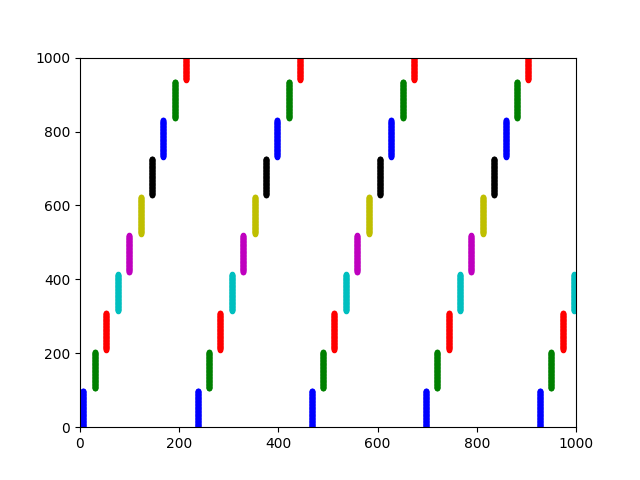

In [12]:
import matplotlib.pyplot as plt
import numpy
import pyNN.utility.plotting as plotting

colours = ['b', 'g', 'r', 'c', 'm', 'y', 'k']

plt.figure()
plt.xlim(0, simtime)
plt.ylim(0, n_neurons * n_populations)
offset = 0
for i, pop_spikes in enumerate(spike_trains):
    colour = colours[i % len(colours)]
    for spike_train in pop_spikes:
        neuron_id = spike_train.annotations['source_index'] + offset
        plt.plot(spike_train, numpy.ones_like(spike_train) * neuron_id, "k.", color=colour)
    offset += len(spike_train)
plt.show()